In [1]:
# dev work for FGN conv layer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (4.0, 3.0)

In [4]:
import torch
import torch.nn as nn
import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

/home/felix/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
# def get_output_shape(module: nn.Module, in_shape: tuple, device='cpu'):
#     # given a model and its in_feat shape
#     # compute the shape of the output
#     # only works for single output modules
#     # does no error checking or timeout, so use at your own risk
    
#     # generate random tensor of right shape
#     r = torch.rand(in_shape, device=device)
    
#     # pass the random tensor through the module
#     o = module(r)
    
#     # return shape as torch.size
#     return o.size()
    

In [6]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np 
import math

In [7]:
class FGN_Conv1d(nn.Module):
    # the fgn version of the convolutional 1d layer
    # tries to handle as many params as Conv1D in the same manner
    
    def __init__(self,
                 in_channels, out_channels, kernel_size,
                 stride=1, dilation=1, padding=0, padding_mode='zeros',
                 covar_type='diag', ordinal=2.0, first_layer=False,
                 **kwargs):
        super(FGN_Conv1d, self).__init__()
        # the associated conv1d layer
        self.Conv1d = nn.Conv1d(in_channels=in_channels ,out_channels=out_channels, kernel_size=kernel_size, 
                                stride=stride, dilation=dilation, padding=padding, padding_mode=padding_mode,
                                **kwargs)
        # input channels
        self.in_channels = in_channels
        # output dimensions 
        self.out_channels = out_channels
        # size of the kernel (analog to the input dimension)
        self.kernel_size = kernel_size
        # stride step
        self.stride = stride
        # dilation between kernel inputs
        self.dilation = dilation
        # padding params
        self.padding = padding
        self.padding_mode = padding_mode
    
        # covariance type for the gaussian: one of 'sphere', 'diag', 'full'
        self.covar_type = covar_type
        # ordinal used for the norm (distance to centers) computation 
        # (1=diamond, 2=euclidean, 3->float('inf')=approach manhattan)
        self.ordinal = ordinal
        # is this the first layer of the network? (ie: does it have only inputs or also gaussian input from previous layer?)
        self.first_layer = first_layer
        # centers of FGNs  
        self.centers = nn.Parameter(torch.Tensor(out_channels, kernel_size), requires_grad=True)
        # size/range of FGNs
        # inverse covariance will actually be used
        if covar_type == 'sphere':
            self.inv_covars = nn.Parameter(torch.Tensor(out_channels,), requires_grad=True)
        elif covar_type == 'diag':
            self.inv_covars = nn.Parameter(torch.Tensor(out_channels, kernel_size,), requires_grad=True)
        elif covar_type == 'full':
            raise Exception('full gaussian type not supported (and unlikely to be considering computation cost)')
        elif covar_type == 'chol':
            raise Exception(' Cholesky full gaussian type not supported (and unlikely to be considering computation cost)')
        else:
            # error
            raise TypeError('covar_type not one of [\'sphere\', \'diag\', \'full\', \'chol\']')
        
        # minimum sigma/range of neurons
        self.eps = 1e-8 
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        # centers init, assuming data normalized to mean 0 (not necessarily true after first layer)
        init.normal_(self.centers, mean=0.0, std=0.1)
        # sigmas init, to be researched further
        s = self.kernel_size

#         self.sigmas.data.uniform_(s-0.5, s+0.5)
        self.inv_covars.data.uniform_(3.0/(s+0.5), 3.0/(s-0.5))

        
    def forward(self, inputs, prev_g = None):
        
        # compute conv output
        c = self.Conv1d.forward(inputs)
        
        # transform the inputs per in/out channels/stride/kernelsize
        batch_size, _, input_len = inputs.size()
        # conv1d padding only does zero padding, but nn.pad does constant
        if self.padding_mode == 'zeros':
            padding_mode_passed = 'constant'
        else:
            padding_mode_passed = self.padding_mode

        # (conv1d doesnt handle different sized paddings on each sides)
        # even though nn.functional.pad does, the code below should future proof it in case they move to left/right pads
        padding_passed = (self.padding, self.padding)
        
        # total numpber of outputs
        num_outputs = int(np.floor((input_len+sum(padding_passed)-self.dilation*(self.kernel_size-1)-1)/self.stride+1))
        # stride the inputs
        strided_inputs = torch.as_strided(input=nn.functional.pad(inputs, pad=padding_passed, mode=padding_mode_passed), 
                                  size=(batch_size,
                                        self.in_channels,
                                        num_outputs,
                                        self.kernel_size, 
                                       ),
                                  stride=((input_len+sum(padding_passed))*(self.in_channels),
                                          input_len+sum(padding_passed), 
                                          self.stride, 
                                          self.dilation))
        
        # distance to centers
        dists = strided_inputs.view(batch_size, self.in_channels, 1, num_outputs, self.kernel_size) - self.centers.view(1, 1, self.out_channels, 1, self.kernel_size)
            
        # computation of gaussian component
        if self.covar_type=='sphere':
            # distance to centers (sum along 1)
            # with ordinal applied,
            # and small value added to prevent problems when ord<1
            # summed along channels (dim 1)
            g = torch.sum( torch.pow( torch.abs(dists)
                                           + 1e-32*float(self.ordinal<1.0),
                                           self.ordinal),
                                dim=(1,4))


            # remember: self.eps defines minimum neuron range (prevents zero range neuron, which can't later grow if needed)
            # with inv_covar applied,
            g = g*(torch.clamp(self.inv_covars.view(1, self.out_channels, 1), max=1.0/self.eps)**2)

        elif self.covar_type=='diag':
            # distance to centers,
            # with inv_covar applied,
            # with ordinal applied,
            # and small value added to prevent problems when ord<1
            g = torch.sum( torch.pow( torch.abs(dists) * 
                                          torch.pow(
                                              torch.clamp(self.inv_covars.view(1, 1, self.out_channels, 1, self.kernel_size), max=1.0/self.eps)**2, 
                                              1./self.ordinal)
                                          + 1e-32*float(self.ordinal<1.0), 
                                          self.ordinal),
                                dim=(1,4))

        else:
            # this should never happen
             raise Exception('Something went wrong with covar_type')
                
        # apply exponential
        g = torch.exp(-g)
            
        # apply prev_g gate if needed
        if prev_g is not None:
            # pad_mode is always zeros
            prev_g_strided = torch.as_strided(input=nn.functional.pad(prev_g, pad=padding_passed, mode='constant'), 
                                              size=(batch_size,
                                                    self.in_channels,
                                                    num_outputs,
                                                    self.kernel_size, 
                                                   ),
                                              stride=((input_len+sum(padding_passed))*(self.in_channels),
                                                      input_len+sum(padding_passed), 
                                                      self.stride, 
                                                      self.dilation))

            # max along channels, kernels
            max_prev_g_strided,_ = torch.max(prev_g_strided, dim=3)
            max_prev_g_strided,_ = torch.max(max_prev_g_strided, dim=1)
            
            # compare with current g
            g = torch.maximum(g, max_prev_g_strided.unsqueeze(1))
            
        # combine conv with gaussian
        res = c*g

        # pass both activity and gaussian component
        return res, g

In [8]:
# test on SPEECHCOMMANDS

In [9]:
resample_rate = 8000
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate=8000, num_workers=2, pin_memory=True)

In [10]:
waveform, sample_rate, label, speaker_id, utterance_number = train_loader.dataset[1]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


<IPython.core.display.Javascript object>


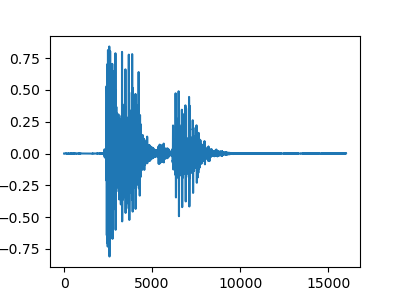

In [11]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

In [12]:
import IPython.display as ipd

In [13]:
ipd.Audio(waveform, rate=sample_rate)

In [14]:
# load a batch to dev on
for b in train_loader:
    print(b[0].size())
    break

/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([32, 1, 8000])


In [15]:
### dev sphere case real inputs
inputs = b[0]
print('inputs', inputs.size())
in_channels = inputs.size()[1]
out_channels = 4
kernel_size = 3
stride = 1
padding = 3
padding_mode = 'zeros'
# 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'
dilation = 2
covar_type='sphere'


print('in_channels, out_channels, kernel_size, stride ',in_channels, out_channels, kernel_size, stride)


centers = torch.Tensor(out_channels, kernel_size)
init.normal_(centers, mean=0.0, std=0.1)
if covar_type == 'sphere':
    inv_covars = torch.Tensor(out_channels,)
if covar_type == 'diag':
    inv_covars = torch.Tensor(out_channels,kernel_size)
inv_covars.data.uniform_(3.0/(kernel_size+0.5), 3.0/(kernel_size-0.5))

print(centers)
print(inv_covars)

inputs torch.Size([32, 1, 8000])
in_channels, out_channels, kernel_size, stride  1 4 3 1
tensor([[ 0.0843, -0.0515,  0.0677],
        [-0.0274, -0.0062, -0.0928],
        [-0.0557,  0.0579,  0.0752],
        [ 0.1611, -0.0073, -0.0836]])
tensor([1.1108, 1.1730, 1.0948, 1.1175])


In [16]:
# # toy inputs
# inputs = torch.arange(0,24, dtype=torch.float).reshape((2,3,4))
# print(inputs.size())
# print('Inputs:\n', inputs)
# centers = torch.arange(0,kernel_size*out_channels, dtype = torch.float).reshape((out_channels,kernel_size))
# print(centers.size())
# print('centers:\n', centers)
# if covar_type == 'sphere':
#     inv_covars = torch.arange(out_channels)
# if covar_type == 'diag':
#     inv_covars = torch.arange(out_channels*kernel_size).reshape(out_channels,kernel_size)
# print('inv_covars:\n', inv_covars)

In [17]:
batch_size, in_channels, input_len = inputs.size()
if padding_mode == 'zeros':
    padding_mode_passed = 'constant'
else:
    padding_mode_passed = padding_mode

# (conv1d doesnt handle different sized paddings on each sides)
# even though nn.functional.pad does
assert type(padding)==int
padding_passed = (padding,padding)

num_outputs = int(np.floor((input_len+2*padding-dilation*(kernel_size-1)-1)/stride+1))
print(num_outputs)

8002


In [18]:
nn.functional.pad(inputs, pad=padding_passed, mode=padding_mode_passed)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [19]:
strided_inputs = torch.as_strided(input=nn.functional.pad(inputs, pad=padding_passed, mode=padding_mode_passed), 
                                  size=(batch_size,
                                        in_channels,
                                        num_outputs,
                                        kernel_size, 
                                       ),
                                  stride=((input_len+sum(padding_passed))*(in_channels),
                                          input_len+sum(padding_passed), 
                                          stride, 
                                          dilation))
print(strided_inputs.size())
print(strided_inputs)

torch.Size([32, 1, 8002, 3])
tensor([[[[ 0.0000e+00,  0.0000e+00, -5.1717e-04],
          [ 0.0000e+00,  5.7257e-04,  9.5431e-05],
          [ 0.0000e+00, -5.1717e-04, -7.1095e-05],
          ...,
          [ 1.4557e-04,  1.5619e-04,  0.0000e+00],
          [ 3.1366e-04,  2.4239e-04,  0.0000e+00],
          [ 1.5619e-04,  0.0000e+00,  0.0000e+00]]],


        [[[ 0.0000e+00,  0.0000e+00,  1.1547e-03],
          [ 0.0000e+00,  7.8951e-04, -6.4045e-04],
          [ 0.0000e+00,  1.1547e-03, -1.0962e-03],
          ...,
          [ 4.0565e-04, -3.3395e-04,  0.0000e+00],
          [ 2.8740e-04, -5.7844e-04,  0.0000e+00],
          [-3.3395e-04,  0.0000e+00,  0.0000e+00]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]]

In [20]:
print(strided_inputs.size())
print(centers.size())

torch.Size([32, 1, 8002, 3])
torch.Size([4, 3])


In [21]:
# unsqueeze to have (batch_size, in channels, out_channels, num_outputs, kernel_size )

In [22]:
# distance to centers
dists = strided_inputs.view(batch_size, in_channels, 1, num_outputs, kernel_size) - centers.view(1, 1, out_channels, 1, kernel_size)
print(dists.size())
print(dists)

torch.Size([32, 1, 4, 8002, 3])
tensor([[[[[-0.0843,  0.0515, -0.0682],
           [-0.0843,  0.0520, -0.0676],
           [-0.0843,  0.0509, -0.0678],
           ...,
           [-0.0841,  0.0516, -0.0677],
           [-0.0839,  0.0517, -0.0677],
           [-0.0841,  0.0515, -0.0677]],

          [[ 0.0274,  0.0062,  0.0923],
           [ 0.0274,  0.0068,  0.0929],
           [ 0.0274,  0.0057,  0.0927],
           ...,
           [ 0.0276,  0.0063,  0.0928],
           [ 0.0278,  0.0064,  0.0928],
           [ 0.0276,  0.0062,  0.0928]],

          [[ 0.0557, -0.0579, -0.0757],
           [ 0.0557, -0.0573, -0.0751],
           [ 0.0557, -0.0584, -0.0752],
           ...,
           [ 0.0558, -0.0578, -0.0752],
           [ 0.0560, -0.0577, -0.0752],
           [ 0.0559, -0.0579, -0.0752]],

          [[-0.1611,  0.0073,  0.0831],
           [-0.1611,  0.0079,  0.0837],
           [-0.1611,  0.0068,  0.0836],
           ...,
           [-0.1609,  0.0075,  0.0836],
           [-0.160

In [23]:
ordinal=2
print(float(ordinal<1.0))

0.0


In [24]:
if covar_type=='sphere':
    
    # distance to centers (sum along 1)
    # with ordinal applied,
    # and small value added to prevent problems when ord<1
    # summed along channels (dim 1)
    g = torch.sum( torch.pow( torch.abs(dists)
                                   + 1e-32*float(ordinal<1.0),
                                   ordinal),
                        dim=(1,-1))
    print(g.size())
    # print(g)

    print(inv_covars.size())

    # g = torch.t(g)
    # remember: self.eps defines minimum neuron range (prevents zero range neuron, which can't later grow if needed)
    # with inv_covar applied,
    g = g*(torch.clamp(inv_covars.view(1, out_channels, 1), max=1.0/1e-6)**2)
    print(g.size())
    print(g)

torch.Size([32, 4, 8002])
torch.Size([4])
torch.Size([32, 4, 8002])
tensor([[[0.0178, 0.0177, 0.0176,  ..., 0.0177, 0.0177, 0.0177],
         [0.0128, 0.0130, 0.0129,  ..., 0.0130, 0.0130, 0.0129],
         [0.0146, 0.0144, 0.0146,  ..., 0.0145, 0.0145, 0.0145],
         [0.0411, 0.0412, 0.0412,  ..., 0.0412, 0.0411, 0.0411]],

        [[0.0175, 0.0179, 0.0180,  ..., 0.0176, 0.0176, 0.0178],
         [0.0132, 0.0128, 0.0127,  ..., 0.0130, 0.0130, 0.0129],
         [0.0143, 0.0145, 0.0145,  ..., 0.0146, 0.0146, 0.0145],
         [0.0414, 0.0411, 0.0410,  ..., 0.0410, 0.0411, 0.0413]],

        [[0.0177, 0.0177, 0.0177,  ..., 0.0177, 0.0177, 0.0177],
         [0.0129, 0.0129, 0.0129,  ..., 0.0129, 0.0129, 0.0129],
         [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
         [0.0412, 0.0412, 0.0412,  ..., 0.0412, 0.0412, 0.0412]],

        ...,

        [[0.0183, 0.0185, 0.0177,  ..., 0.0174, 0.0175, 0.0167],
         [0.0120, 0.0116, 0.0122,  ..., 0.0134, 0.0133, 0.0133],
  

In [25]:
if covar_type=='diag':
    # distance to centers,
    # with inv_covar applied,
    # with ordinal applied,
    # and small value added to prevent problems when ord<1
    g = torch.sum( torch.pow( torch.abs(dists) * 
                                  torch.pow(
                                      torch.clamp(inv_covars.view(1, 1, out_channels, 1, kernel_size), max=1.0/1e-6)**2, 
                                      1./ordinal)
                                  + 1e-32*float(ordinal<1.0), 
                                  ordinal),
                        dim=(1,-1))
    print(g.size())
    # print(g)

    print(inv_covars.size())

    # g = torch.t(g)
    # remember: self.eps defines minimum neuron range (prevents zero range neuron, which can't later grow if needed)
    # with inv_covar applied,
    print(g.size())
    print(g)

In [26]:
# apply exponential
g = torch.exp(-g)
print(g.size())
print(g)

torch.Size([32, 4, 8002])
tensor([[[0.9824, 0.9824, 0.9825,  ..., 0.9825, 0.9825, 0.9825],
         [0.9873, 0.9871, 0.9872,  ..., 0.9871, 0.9871, 0.9871],
         [0.9855, 0.9857, 0.9855,  ..., 0.9856, 0.9856, 0.9856],
         [0.9597, 0.9596, 0.9597,  ..., 0.9597, 0.9597, 0.9597]],

        [[0.9827, 0.9823, 0.9821,  ..., 0.9826, 0.9826, 0.9824],
         [0.9869, 0.9873, 0.9874,  ..., 0.9871, 0.9871, 0.9872],
         [0.9858, 0.9856, 0.9856,  ..., 0.9855, 0.9855, 0.9856],
         [0.9594, 0.9597, 0.9598,  ..., 0.9598, 0.9598, 0.9595]],

        [[0.9825, 0.9825, 0.9825,  ..., 0.9825, 0.9825, 0.9825],
         [0.9871, 0.9871, 0.9871,  ..., 0.9871, 0.9871, 0.9871],
         [0.9856, 0.9856, 0.9856,  ..., 0.9856, 0.9856, 0.9856],
         [0.9596, 0.9596, 0.9596,  ..., 0.9596, 0.9596, 0.9596]],

        ...,

        [[0.9819, 0.9816, 0.9825,  ..., 0.9828, 0.9826, 0.9834],
         [0.9880, 0.9885, 0.9878,  ..., 0.9867, 0.9868, 0.9868],
         [0.9849, 0.9845, 0.9846,  ..., 0.98

In [27]:
# g might also need to be strided
# pretend inputs is prev_g
prev_g = inputs
# pad_mode is always zeros
prev_g_strided = torch.as_strided(input=nn.functional.pad(inputs, pad=padding_passed, mode='constant'), 
                                  size=(batch_size,
                                        in_channels,
                                        num_outputs,
                                        kernel_size, 
                                       ),
                                  stride=((input_len+sum(padding_passed))*(in_channels),
                                          input_len+sum(padding_passed), 
                                          stride, 
                                          dilation))
print(prev_g_strided.size())
print(prev_g_strided)
# max along channels, kernels
prev_g_strided,_ = torch.max(prev_g_strided, dim=-1)
prev_g_strided,_ = torch.max(prev_g_strided, dim=1)

print(prev_g_strided.size())
print(prev_g_strided)

torch.Size([32, 1, 8002, 3])
tensor([[[[ 0.0000e+00,  0.0000e+00, -5.1717e-04],
          [ 0.0000e+00,  5.7257e-04,  9.5431e-05],
          [ 0.0000e+00, -5.1717e-04, -7.1095e-05],
          ...,
          [ 1.4557e-04,  1.5619e-04,  0.0000e+00],
          [ 3.1366e-04,  2.4239e-04,  0.0000e+00],
          [ 1.5619e-04,  0.0000e+00,  0.0000e+00]]],


        [[[ 0.0000e+00,  0.0000e+00,  1.1547e-03],
          [ 0.0000e+00,  7.8951e-04, -6.4045e-04],
          [ 0.0000e+00,  1.1547e-03, -1.0962e-03],
          ...,
          [ 4.0565e-04, -3.3395e-04,  0.0000e+00],
          [ 2.8740e-04, -5.7844e-04,  0.0000e+00],
          [-3.3395e-04,  0.0000e+00,  0.0000e+00]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]]

In [28]:
g = torch.maximum(g, prev_g_strided.unsqueeze(1))
print(g.size())

torch.Size([32, 4, 8002])


In [29]:
### put it all together and test on classes
test_fgn_layer = FGN_Conv1d(in_channels=1, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, dilation=dilation,
                            padding=padding, padding_mode=padding_mode,
                            covar_type=covar_type, ordinal=ordinal, first_layer=True,)

test_fgn_layer2 = FGN_Conv1d(in_channels=out_channels, out_channels=2*out_channels, 
                            kernel_size=2*kernel_size, stride=2*stride, dilation=2*dilation,
                            padding=2*padding, padding_mode='zeros',
                            covar_type='diag', ordinal=3.0, first_layer=False,)

In [30]:
test_conv1d_layer = nn.Conv1d(in_channels=1, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, dilation=dilation,
                            padding=padding, padding_mode=padding_mode)

In [31]:
test_conv1d_layer2 = nn.Conv1d(in_channels=out_channels, out_channels=2*out_channels, 
                            kernel_size=2*kernel_size, stride=2*stride, dilation=2*dilation,
                            padding=2*padding, padding_mode='zeros')

In [32]:
### test composition
res, g = test_fgn_layer.forward(b[0])
print(res.size())
print(g.size())

torch.Size([32, 4, 8002])
torch.Size([32, 4, 8002])


In [33]:
res2, g2 = test_fgn_layer2.forward(res,g)
print(res2.size())
print(g2.size())

torch.Size([32, 8, 3997])
torch.Size([32, 8, 3997])


In [34]:
r1 = test_conv1d_layer.forward(b[0])
print(r1.size())

torch.Size([32, 4, 8002])


In [35]:
r2 = test_conv1d_layer2.forward(r1)
print(r2.size())

torch.Size([32, 8, 3997])
